Sistem Rekomendasi Buku

- Nama: Radya Ardi Ninang Pudyastuti
- Dataset: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data

----------------

# Import Library

Langkah pertama adalah melakukan import library yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import pickle
import os
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings('ignore')

# Loading Dataset

Langkah selanjutnya adalah melakukan loading dataset yang berasal dari kaggle, kemudian dibaca ke dalam bentuk DataFrame Pandas.

Dari link tersebut, akan digunakan 2 dataset, yaitu book dan rating, untuk membangun content dan collaborative filtered book recommendation system.  

In [2]:
# Download latest version
path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")
print("Path to dataset files:", path)

book = os.path.join(path, "Books.csv")
rating = os.path.join(path, "Ratings.csv")

Path to dataset files: /kaggle/input/book-recommendation-dataset


menampilkan dataset book

In [3]:
df_book = pd.read_csv(book)
df_book

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


menampilkan dataset rating

In [4]:
df_rating = pd.read_csv(rating)
df_rating

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


# Eksplorasi Data Analysis (EDA)

##### Books

Pada tahap Eksplorasi Data atau Data Understanding akan dilakukan bertahap sesuai dengan dataset masing-masing. yang pertama adalah dataset books.

In [5]:
# memeriksa ukuran dimensi data untuk mengetahui berapa jumlah baris dan kolom pada dataset book.
print(f'dimensi dataset buku:', df_book.shape)

dimensi dataset buku: (271360, 8)


pada data buku, memiliki 271360 baris dan 8 kolom

In [6]:
# memeriksa nilai yang hilang (missing value) pada dataset buku
df_book.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


berdasarkan tabel di atas, terdapat beberapa missing value pada data buku, yaitu pada kolom Book-Author, Publisher, dan Image-URL-L. dalam hal ini akan dilakukan penanganan dengan cara imputasi data pada kolom Book-Author dan Publisher, sedangkan pada kolom Image-URL-L akan dilakukan penghapusan.

In [7]:
# memeriksa jumlah nilai yang duplikat pada judul buku (Book-Title) pada dataset.
df_book.duplicated(["Book-Title"]).sum()

np.int64(29225)

dari hasil di atas didapatkan data duplikat dari data books berjumlah 29225

In [8]:
# Memeriksa tipe data pada setiap kolom
df_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


dari hasil pengecekan di atas, tipe data tiap kolom sudah sesuai. sehingga tidak memerlukan penanganan.

In [9]:
#melihat jumlah karya yang dihasilkan oleh penulis buku (Book-Author)
df_book['Book-Author'].value_counts().head(10)

,count
Book-Author,
Agatha Christie,632
William Shakespeare,567
Stephen King,524
Ann M. Martin,423
Carolyn Keene,373
Francine Pascal,372
Isaac Asimov,330
Nora Roberts,315
Barbara Cartland,307


Dari hasil analisis, diperoleh daftar 10 besar penulis dengan jumlah buku terbanyak. Penulis dengan jumlah terbanyak adalah **Agatha Christie** dengan 632 buku, diikuti oleh **William Shakespeare** (567 buku) dan **Stephen King** (524 buku).


In [10]:
#melihat jumlah karya yang dihasilkan oleh suatu publisher
df_book['Publisher'].value_counts().head(10)

,count
Publisher,
Harlequin,7535
Silhouette,4220
Pocket,3905
Ballantine Books,3783
Bantam Books,3646
Scholastic,3160
Simon &amp; Schuster,2971
Penguin Books,2844
Berkley Publishing Group,2771


Berdasarkan hasil agregasi data:
- **Harlequin** menjadi penerbit dengan jumlah buku terbanyak, yaitu sebanyak 7.535 buku.
- Diikuti oleh **Silhouette** (4.220 buku), **Pocket** (3.905 buku), dan **Ballantine Books** (3.783 buku).


### Rating

In [11]:
# Memeriksa dimensi ukuran dataset rating
print(f'dimensi dataset rating:', df_rating.shape)

dimensi dataset rating: (1149780, 3)


dari hasil di atas, data rating memiliki 1149780 baris dan 3 kolom

In [12]:
# Memeriksa jumlah nilai yang hilang (missing value) pada dataset rating
df_rating.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


Dari hasil di atas, data rating tidak memiliki missing value. sehingga tidak perlu dilakukan penanganan

In [13]:
# Memeriksa nilai yang duplikat pada dataset rating
df_rating.duplicated().sum()

np.int64(0)

data rating tidak memiliki data duplikat. sehingga tidak perlu dilakukan penanganan

In [14]:
# memeriksa tipe data pada setiap fitur kolom
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


dari informasi di atas, data rating sudah memiliki tipe data yang sesuai

In [15]:
#Menghitung jumlah buku berdasarkan ratingnya.
df_rating['Book-Rating'].value_counts()

,count
Book-Rating,
0,716109
8,103736
10,78610
7,76457
9,67541
5,50974
6,36924
4,8904
3,5996


berdasarkan tabel di atas, didapatkan insight sebagai berikut:
- Nilai **0**  paling banyak muncul (**>716 ribu entri**), menandakan bahwa rating ini kemungkinan besar memberikan informasi bahwa user **tidak memberikan rating eksplisit**.
- Nilai **8–10** juga sangat dominan, menunjukkan adanya kecenderungan pengguna untuk memberikan rating yang **positif**, atau user menyukai buku tersebut.
- Nilai **1–3** sangat jarang diberikan, yang mungkin menunjukkan bias positif pada sistem.


In [16]:
#memeriksa pengguna yang memberikan rating terbanyak dalam dataset
df_rating['User-ID'].value_counts().head(10)

,count
User-ID,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
212898,4785
278418,4533
76352,3367
110973,3100


Tabel di atas menunjukkan bahwa hanya sebagian kecil pengguna yang sangat aktif memberikan rating buku, dengan User-ID 11676 menjadi yang paling aktif sebanyak 13.602 rating. Pola ini mencerminkan ketimpangan distribusi kontribusi user (power-law), yang umum dalam sistem rekomendasi. Pengguna-pengguna aktif seperti ini bisa sangat berguna dalam pelatihan model collaborative filtering, sementara pengguna pasif mungkin menimbulkan tantangan seperti cold-start.


In [17]:
#Menampilkan buku yang paling sering diberikan rating berdasarkan nomor ISBN.
df_rating['ISBN'].value_counts().head(10)

,count
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
044023722X,647
0679781587,639
0142001740,615
067976402X,614


Hasil ini menunjukkan 10 buku dengan ISBN yang paling banyak mendapat rating dari pengguna, dengan ISBN `0971880107` menempati urutan pertama sebanyak 2.502 rating. Buku-buku ini kemungkinan merupakan buku populer yang dikenal luas oleh pengguna. Informasi ini penting untuk sistem rekomendasi karena item-item populer seperti ini cenderung memiliki representasi yang lebih kuat dalam model, sedangkan buku dengan sedikit rating mungkin kurang informatif dan berisiko terkena cold-start.


# Data Preprocessing

In [18]:
books = df_book
ratings = df_rating

### Books

Langkah data preprocessing yang pertama pada dataset books adalah mengatasi missing value pada fitur Book-Author, Publisher, dan Image-URL-L.

pada kolom Book-Author, Publisher akan diisi dengan "Unknown". sedangkan pada kolom Image-URL-L, data yang kosong akan di drop, karena jumlahnya masih sedikit.  

In [19]:
#Mengisi missing value
books['Book-Author'].fillna('Unknown', inplace=True)
books['Publisher'].fillna('Unknown', inplace=True)
books.dropna(subset=['Image-URL-L'], inplace=True)

In [20]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0


Langkah selanjutnya adalah menghapus data duplikat pada dataset books, agar tidak ada data yang redundan.

In [21]:
books.duplicated().sum()
books.drop_duplicates(inplace=True)

In [22]:
books.duplicated().sum()

np.int64(0)

Mengubah kolom Year-Of-Publication menjadi tipe data numerik (int) dan membersihkan data tahun yang tidak valid.

In [23]:
# mengubah Year-Of-Publication ke int
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
books = books[(books['Year-Of-Publication'] >= 1000) & (books['Year-Of-Publication'] <= 2025)]

Melakukan normalisasi teks dengan mengubah huruf menjadi lowercase dan menghapus spasi berlebih di awal/akhir string agar konsisten dalam format penulisan.

In [24]:
# lowercase dan strip whitespace
books['Book-Title'] = books['Book-Title'].str.lower().str.strip()
books['Book-Author'] = books['Book-Author'].str.lower().str.strip()
books['Publisher'] = books['Publisher'].str.lower().str.strip()

In [25]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,classical mythology,mark p. o. morford,2002,oxford university press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,clara callan,richard bruce wright,2001,harperflamingo canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,decision in normandy,carlo d'este,1991,harperperennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999,farrar straus giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,the mummies of urumchi,e. j. w. barber,1999,w. w. norton &amp; company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,there's a bat in bunk five,paula danziger,1988,random house childrens pub (mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,from one to one hundred,teri sloat,1991,dutton books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,lily dale : the true story of the town that ta...,christine wicker,2004,harpersanfrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,republic (world's classics),plato,1996,oxford university press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


dataframe di atas menampilkan hasil normalisasi pada kolom Book-title, book-author, dan publisher dimana seluruh huruf sudah dalam bentuk huruf kecil (tidak ada huruf kapital).

Menyaring buku-buku populer yang telah mendapatkan lebih dari 50 rating.

In [26]:
# Filter buku populer
popular_books = ratings['ISBN'].value_counts()
popular_isbn = popular_books[popular_books > 50].index
books_filtered = books[books['ISBN'].isin(popular_isbn)].drop_duplicates(subset='Book-Title')

Membuat fitur gabungan dari beberapa kolom informasi buku sebagai dasar analisis yang digunakan untuk proses transformasi teks dan pencocokan kemiripan antar buku dalam content-based filtering.

In [27]:
# Menggabungkan fitur yang relevan
books_filtered['combined_features'] = (
    books_filtered['Book-Title'].fillna('') + ' ' +
    books_filtered['Book-Author'].fillna('') + ' ' +
    books_filtered['Publisher'].fillna('')
)

In [28]:
books_filtered

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,combined_features
18,0440234743,the testament,john grisham,1999,dell,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,http://images.amazon.com/images/P/0440234743.0...,the testament john grisham dell
19,0452264464,beloved (plume contemporary fiction),toni morrison,1994,plume,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,http://images.amazon.com/images/P/0452264464.0...,beloved (plume contemporary fiction) toni morr...
26,0971880107,wild animus,rich shapero,2004,too far,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,wild animus rich shapero too far
27,0345402871,airframe,michael crichton,1997,ballantine books,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,http://images.amazon.com/images/P/0345402871.0...,airframe michael crichton ballantine books
28,0345417623,timeline,michael crichton,2000,ballantine books,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,http://images.amazon.com/images/P/0345417623.0...,timeline michael crichton ballantine books
...,...,...,...,...,...,...,...,...,...
56909,0679459618,dr. death: a novel,jonathan kellerman,2000,random house trade,http://images.amazon.com/images/P/0679459618.0...,http://images.amazon.com/images/P/0679459618.0...,http://images.amazon.com/images/P/0679459618.0...,dr. death: a novel jonathan kellerman random h...
60057,0061092886,the fallen man (joe leaphorn novels),tony hillerman,1997,harpertorch,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,http://images.amazon.com/images/P/0061092886.0...,the fallen man (joe leaphorn novels) tony hill...
62414,0553575090,deception on his mind,elizabeth george,1998,bantam,http://images.amazon.com/images/P/0553575090.0...,http://images.amazon.com/images/P/0553575090.0...,http://images.amazon.com/images/P/0553575090.0...,deception on his mind elizabeth george bantam
70583,067155302X,harvest,tess gerritsen,1997,pocket,http://images.amazon.com/images/P/067155302X.0...,http://images.amazon.com/images/P/067155302X.0...,http://images.amazon.com/images/P/067155302X.0...,harvest tess gerritsen pocket


berdasarkan dataframe di atas, telah dilakukan filtering terhadap buku-buku populer yang telah memiliki lebih dari 50 rating, dibuktikan dengan berkurangnya jumlah baris yang ada pada dataframe ini, yaitu 1889 baris. selain itu, pada data ini sudah bertambah kolom combined feature yang memuat kolom book-title, book-author, dan publisher.

Mengubah teks gabungan menjadi representasi numerik menggunakan metode TF-IDF yang digunakan untuk proses pencocokan kemiripan antar buku dalam content-based filtering. Proses ini menghasilkan matriks fitur dari kata-kata penting yang merepresentasikan karakteristik tiap buku.

In [29]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the combined features
tfidf_matrix = tfidf.fit_transform(books_filtered['combined_features'])

# Now you can get the feature names (optional, but good for inspection)
feature_names = tfidf.get_feature_names_out()
feature_names

array(['10', '100', '1027', ..., 'zoya', 'zukav', 'â¼bbe'], dtype=object)

memeriksa dimensi matriks TF-IDF

In [30]:
# Fit and transform the combined features
tfidf_matrix = tfidf.fit_transform(books_filtered['combined_features'])
tfidf_matrix.shape

(1889, 3458)

Mengonversi matriks TF-IDF dari format sparse matrix menjadi dense matrix

In [31]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Membuat DataFrame dari matriks TF-IDF dalam format dense, dengan baris berupa judul buku dan kolom berupa kata-kata fitur, lalu menampilkan sampel acak 10 kata dan 10 buku untuk eksplorasi data dan pemahaman terhadap representasi teks hasil vektorisasi.

In [32]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=books_filtered['Book-Title']
).sample(10, axis=1,replace=True).sample(10, axis=0)

,mint,jung,estes,pubns,fits,cloud,final,parkhurst,outbreak,nightmares
Book-Title,,,,,,,,,,
moonlight becomes you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the bone collector (lincoln rhyme novels (paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
congo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"the amber spyglass (his dark materials, book 3)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
my dream of you,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pop goes the weasel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
back when we were grownups : a novel (ballantine reader's circle),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
billy straight : a novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
memoirs of a geisha,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tabel ini menunjukkan vektor representasi tiap buku berdasarkan hasil TF-IDF. Baris adalah judul buku, dan kolom adalah kata-kata unik yang diekstraksi. Nilai 0.0 berarti kata tidak relevan untuk buku tersebut. Matriks ini digunakan untuk menghitung kemiripan antar buku dalam Content-Based Filtering.

Menghitung skor kemiripan antar buku berdasarkan cosine similarity dari matriks TF-IDF, yang digunakan untuk menentukan seberapa mirip satu buku dengan buku lainnya dalam content-based filtering. Hasilnya berupa matriks simetri dengan nilai antara 0 hingga 1.

In [33]:
# Menghitung cosine similarity antar buku
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Membuat indeks pencarian berdasarkan judul buku untuk mempermudah proses pencarian posisi buku tertentu dalam data. Indeks ini digunakan saat mengambil skor kemiripan dari matriks cosine similarity.

In [34]:
# Membuat indeks pencarian berdasarkan judul
indices = pd.Series(range(len(books_filtered)), index=books_filtered['Book-Title']).drop_duplicates()

### Rating

Menghapus data rating dengan nilai 0 yang dianggap tidak merepresentasikan penilaian sebenarnya.

In [35]:
#Menghapus rating 0
print(f"Sebelum dibersihkan: {df_rating.shape}")
ratings_cleaned = df_rating[df_rating['Book-Rating'] > 0]
print(f"Setelah dibersihkan: {ratings_cleaned.shape}")

Sebelum dibersihkan: (1149780, 3)
Setelah dibersihkan: (433671, 3)


Menyaring data rating agar hanya mencakup buku yang aktif (minimal 10 rating) dan pengguna yang aktif (minimal 5 rating).

In [36]:
active_books = ratings_cleaned['ISBN'].value_counts()[ratings_cleaned['ISBN'].value_counts() >= 10].index
active_users = ratings_cleaned['User-ID'].value_counts()[ratings_cleaned['User-ID'].value_counts() >= 5].index

ratings_filtered = ratings_cleaned[ratings_cleaned['ISBN'].isin(active_books) & ratings_cleaned['User-ID'].isin(active_users)]
ratings_filtered

,User-ID,ISBN,Book-Rating
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
133,276822,0060096195,10
137,276822,0375821813,9
...,...,...,...
1149738,276688,0688156134,8
1149743,276688,0836218655,10
1149744,276688,0836236688,10
1149761,276704,0345386108,6


Dataframe di atas menampilkan hasil filtering yang menghasilkan 107.729 interaksi dari pengguna dan buku yang aktif.

Menyalin data rating hasil filtering dan melakukan encoding terhadap User-ID dan ISBN menjadi format angka dengan LabelEncoder, agar dapat digunakan dalam model collaborative filtering yang memerlukan input numerik

In [37]:
ratings = ratings_filtered.copy()

# Encode user dan book jadi integer index
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

Mengubah nilai asli User-ID dan ISBN menjadi representasi angka menggunakan hasil encoding, dan menyimpannya ke kolom baru (user dan book).

In [38]:
ratings['user'] = user_enc.fit_transform(ratings['User-ID'])
ratings['book'] = book_enc.fit_transform(ratings['ISBN'])

Menghitung jumlah unik pengguna (user) dan buku (book) dalam data rating. Informasi ini digunakan untuk mengetahui dimensi dari matriks interaksi user-item yang akan dibentuk dalam collaborative filtering.

In [39]:
num_users = ratings['user'].nunique()
num_books = ratings['book'].nunique()

Memilih hanya kolom user, book, dan Book-Rating dari dataset untuk membentuk matriks interaksi yang merepresentasikan hubungan antara pengguna dan buku dalam collaborative filtering.

In [40]:
ratings = ratings[['user', 'book', 'Book-Rating']]

Membagi data menjadi data latih dan data uji untuk mempersiapkan proses pelatihan dan evaluasi model dengan ratio 80:20

In [41]:
#Splitting data
X = ratings[['user', 'book']]
y = ratings['Book-Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Pemodelan

Dalam proyek ini, sistem rekomendasi dibangun dengan memanfaatkan dua pendekatan utama, yaitu:
1. **Content-Based Filtering** memberikan rekomendasi berdasarkan kemiripan atribut antar item (dalam hal ini, buku). Sistem ini menganalisis fitur-fitur seperti penulis, judul, dan informasi buku lainnya, lalu mencari buku yang memiliki karakteristik serupa dengan buku yang disukai pengguna sebelumnya. Pendekatan ini tidak bergantung pada data dari pengguna lain, melainkan fokus pada konten dari item itu sendiri.
2. **Collaborative Filtering** memberikan rekomendasi berdasarkan perilaku pengguna lain. Sistem ini mengasumsikan bahwa jika dua pengguna memiliki selera yang mirip, maka buku yang disukai oleh satu pengguna kemungkinan juga disukai oleh pengguna lainnya. Pendekatan ini menggunakan interaksi antar pengguna dan item, tanpa memerlukan informasi detail dari konten buku itu sendiri.


-------------------
## Content Based Section

In [42]:
# Fungsi rekomendasi berdasarkan judul buku
def recommend_books_content_based(title, cosine_sim=cosine_sim, top_n=5):
    idx = indices.get(title)
    if idx is None:
        return ["Judul tidak ditemukan."]

    idx = int(idx)
    if idx >= cosine_sim.shape[0]:
        return ["Judul ditemukan, tetapi indeksnya tidak valid dalam matriks kesamaan."]


    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    book_indices = [i[0] for i in sim_scores]

    try:
        recommended_books_info = books_filtered.iloc[book_indices][['Book-Title', 'Book-Author', 'Publisher']]
    except IndexError:
        return ["Terjadi kesalahan saat mengambil informasi buku. Mungkin ada masalah dengan indeks buku yang direkomendasikan."]

    return recommended_books_info.reset_index(drop=True)

Fungsi ini menghasilkan rekomendasi **5 buku serupa** berdasarkan judul buku yang diberikan. Sistem menggunakan **cosine similarity** antar judul buku yang telah ditransformasikan dengan **TF-IDF**, kemudian memilih buku dengan skor kemiripan tertinggi. Informasi yang ditampilkan mencakup judul, penulis, dan penerbit buku.


In [43]:
# Membuat ground truth dari user yang memberi rating >= 7
user_likes = ratings_filtered[ratings_filtered['Book-Rating'] >= 7]
user_true_books = user_likes.groupby('User-ID')['ISBN'].apply(list).to_dict()

# Mengambil rekomendasi untuk user berdasarkan buku yang pernah mereka baca
def get_user_recommendations(user_id, top_n=5):
    user_books = ratings_filtered[ratings_filtered['User-ID'] == user_id]['ISBN'].tolist()
    recommended_isbns = set()

    for isbn in user_books:
        title_row = books[books['ISBN'] == isbn]
        if not title_row.empty:
            title = title_row['Book-Title'].values[0]
            # Call the content-based recommendation function
            recs = recommend_books_content_based(title)
            if isinstance(recs, pd.DataFrame):
                # Need to get ISBNs for the recommended titles from the original 'books' dataframe
                # as 'recs' only contains title, author, publisher
                rec_isbns = books[books['Book-Title'].isin(recs['Book-Title'])]['ISBN'].tolist()
                recommended_isbns.update(rec_isbns)

    # Filter out books the user has already read from the recommendations
    already_read_isbns = ratings_filtered[ratings_filtered['User-ID'] == user_id]['ISBN'].tolist()
    recommended_isbns = [isbn for isbn in recommended_isbns if isbn not in already_read_isbns]

    # Let's get the titles of the books the user has already read
    already_read_titles = books[books['ISBN'].isin(already_read_isbns)]['Book-Title'].tolist()

    # Convert recommended ISBNs back to titles for the return
    recommended_titles = books[books['ISBN'].isin(list(recommended_isbns))]['Book-Title'].tolist()

    # Return both recommended titles and already read titles
    return recommended_titles[:top_n], already_read_titles[:top_n] # Limit both lists to top_n for consistency with the call

Fungsi `get_user_recommendations()` menghasilkan daftar rekomendasi buku untuk seorang user berdasarkan buku-buku yang telah mereka beri rating ≥ 7. Untuk setiap buku yang telah dibaca user, sistem memanggil fungsi content-based filtering untuk mencari buku serupa berdasarkan judul.

Rekomendasi dikembalikan dalam bentuk:
- **Buku yang direkomendasikan (judul)** yang belum pernah dibaca user
- **Daftar buku yang sudah pernah dibaca** (judul), sebagai referensi

Rekomendasi dibatasi sejumlah `top_n` buku (default 5 judul).

In [44]:
# Precision@K evaluasi (update the function call within this as well)
def precision_at_k_content_based(user_true_books, top_n=5):
    precision_scores = []
    tested_users = list(user_true_books.keys())[:100]  # Sampling user

    for user_id in tested_users:
        true_books = set(user_true_books[user_id])
        # Call the content-based recommendation function and unpack only the recommended titles
        rec_books, _ = get_user_recommendations(user_id, top_n)

        # We need to compare ISBNs, not titles, for evaluation against user_true_books
        # Convert recommended titles back to ISBNs
        rec_isbns = books[books['Book-Title'].isin(rec_books)]['ISBN'].tolist()

        if not rec_isbns:
            continue

        hits = sum([1 for isbn in rec_isbns if isbn in true_books])
        precision_scores.append(hits / top_n)

    if not precision_scores: # Handle case where no users were tested or no recommendations were generated
        return 0.0

    return sum(precision_scores) / len(precision_scores)



Fungsi `precision_at_k_content_based()` menghitung rata-rata precision dari 100 user terpilih.  
Evaluasi dilakukan dengan membandingkan ISBN buku rekomendasi terhadap buku yang pernah diberi rating ≥ 7.  
Metrik ini menunjukkan seberapa relevan rekomendasi yang diberikan sistem dalam Top-K pilihan.

Bagian ini menjalankan evaluasi akurasi rekomendasi menggunakan metrik **Precision@5**, serta menguji fungsi rekomendasi berdasarkan data riil pengguna (contoh: user ID 276688).  
Output menunjukkan daftar buku yang telah dibaca user dan rekomendasi buku baru dari sistem content-based filtering.

In [45]:
# Menjalankan evaluasi
precision_cb = precision_at_k_content_based(user_true_books, top_n=5)
print(f"Precision@5 untuk Content-Based Filtering: {precision_cb:.4f}")

user_id = 276688
# The get_user_recommendations function now returns two lists: recommended titles and already read titles
recommended_books, already_read = get_user_recommendations(user_id, top_n=5)

print("Buku yang sudah dibaca dan dinilai user:")
for book in already_read:
    print("-", book)

print("\nRekomendasi buku untuk user:")
for book in recommended_books:
    print("-", book)

Precision@5 untuk Content-Based Filtering: 0.0093
Buku yang sudah dibaca dan dinilai user:
- basket case
- stalker: a novel (peter decker &amp; rina lazarus novels (hardcover))
- in pursuit of the proper sinner
- missing joseph
- wiener dog art

Rekomendasi buku untuk user:
- lucky you
- sick puppy
- ashes to ashes
- playing for the ashes
- lucky you


Hasil evaluasi menunjukkan nilai **Precision@5 sebesar 0.0093**, yang berarti bahwa dari 5 rekomendasi yang diberikan untuk masing-masing user, rata-rata hanya sekitar 0.0093 (kurang dari 1%) yang benar-benar sesuai dengan preferensi pengguna (berdasarkan data rating ≥ 7).

Hasil rekomendasi untuk user ID 276688:
- **Buku yang telah dibaca**: *basket case*, *stalker*, *in pursuit of the proper sinner*, dll.
- **Rekomendasi sistem**: *lucky you*, *sick puppy*, *ashes to ashes*, dll.

Meskipun rekomendasi tampak relevan secara tematik, nilai presisinya masih rendah, mengindikasikan bahwa penyempurnaan fitur atau pendekatan mungkin dibutuhkan.


Pada bagian ini dilakukan pengujian sistem rekomendasi content-based filtering menggunakan input judul buku **"american gods"**. Sistem akan mencari dan menampilkan buku-buku lain yang memiliki kemiripan konten berdasarkan fitur teks judul dan deskripsi lainnya.

In [46]:
# uji coba model with the renamed function
print("\nUji coba rekomendasi buku berdasarkan judul:")
print(recommend_books_content_based('american gods'))


Uji coba rekomendasi buku berdasarkan judul:
               Book-Title  Book-Author       Publisher
0  american gods: a novel  neil gaiman  william morrow
1                stardust  neil gaiman       perennial
2              neverwhere  neil gaiman            avon
3                coraline  neil gaiman   harpercollins
4              good omens  neil gaiman       ace books


Berdasarkan hasil output uji coba model di atas, sistem berhasil menghasilkan daftar buku yang memiliki kemiripan konten, ditunjukkan dari kemunculan karya-karya lain dari penulis yang sama (Neil Gaiman), serta buku lain dengan karakteristik serupa.

----
## Collaborative Filtering

Membangun model collaborative filtering berbasis Neural Collaborative Filtering (NCF) dengan arsitektur neural network. Model ini menggunakan embedding untuk memetakan user dan item ke dalam vektor dimensi rendah, kemudian menggabungkannya dan melewatkannya ke layer dense untuk mempelajari pola interaksi yang kompleks antar pengguna dan buku. Model ini dikompilasi menggunakan fungsi loss mse (mean squared error) dan optimizer adam.

In [47]:
#Membangun model Neural Network Model (NCF)
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

# Input
user_input = Input(shape=(1,))
book_input = Input(shape=(1,))

# Embedding
user_embedding = Embedding(num_users, 32)(user_input)
book_embedding = Embedding(num_books, 32)(book_input)

user_vec = Flatten()(user_embedding)
book_vec = Flatten()(book_embedding)

# Concatenate
concat = Concatenate()([user_vec, book_vec])
dense = Dense(128, activation='relu')(concat)
drop = Dropout(0.5)(dense)
output = Dense(1)(drop)

model = Model([user_input, book_input], output)
model.compile(loss='mse', optimizer='adam')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 32)     │    396,480 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 32)     │    180,544 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 585,473 (2.23 MB)

 Trainable params: 585,473 (2.23 MB)

 Non-trainable params: 0 (0.00 B)

Model menggunakan dua input embedding untuk User dan Item (buku), masing-masing berdimensi 32. Hasil embedding diratakan (flatten), lalu digabungkan (concatenate) dan diproses oleh dua layer dense dengan dropout untuk regularisasi. Output model berupa prediksi rating tunggal. Total parameter yang dilatih sebanyak 585.473.


In [48]:
# Melatih model neural collaborative filtering menggunakan data pelatihan selama 5 epoch dengan batch size 256.
history = model.fit(
    [X_train['user'], X_train['book']],
    y_train,
    validation_data=([X_test['user'], X_test['book']], y_test),
    epochs=5,
    batch_size=256
)

Epoch 1/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 37.5639 - val_loss: 3.0810
Epoch 2/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.3795 - val_loss: 2.7609
Epoch 3/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 3.0084 - val_loss: 2.6717
Epoch 4/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.8865 - val_loss: 2.6316
Epoch 5/5
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.8343 - val_loss: 2.5897


In [49]:
#Menghitung nilai RMSE
y_pred = model.predict([X_test['user'].values, X_test['book'].values])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.4f}')

674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 1.6092


Model Collaborative Filtering menghasilkan RMSE sebesar 1.6089, yang menunjukkan rata-rata kesalahan prediksi rating sekitar 1.6 poin dari nilai sebenarnya.

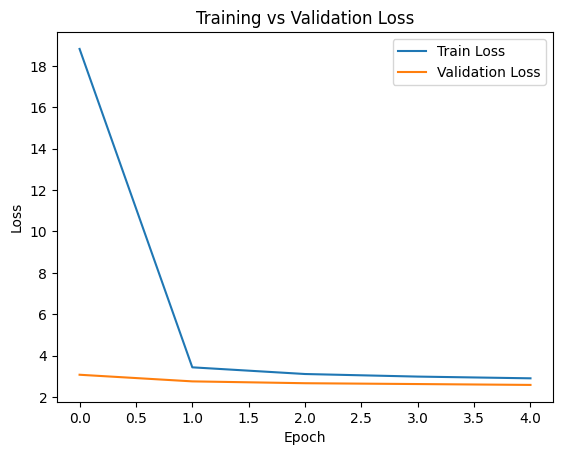

In [50]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.show()

Berdasarkan grafik di atas, **model menunjukkan penurunan nilai loss pada data latih dan validasi** seiring bertambahnya epoch, yang mengindikasikan bahwa **model berhasil belajar dan tidak mengalami overfitting**. Perbedaan nilai yang kecil antara train loss dan validation loss juga menunjukkan kestabilan performa model.

----
Selanjutnya adalah membuat fungsi rekomendasi buku berbasis collaborative filtering dengan input user_id. Fungsi ini akan mengidentifikasi buku-buku yang belum pernah diberi rating oleh pengguna tersebut, kemudian memprediksi rating potensial menggunakan model yang telah dilatih. Buku-buku dengan prediksi tertinggi akan direkomendasikan, dan hasilnya dikembalikan dalam bentuk daftar judul dan penulis. Pendekatan ini merekomendasikan buku berdasarkan pola interaksi pengguna lain yang mirip.

In [51]:
def recommend_books(user_id, model, ratings_df, book_df, top_n=10):
    # Encode user_id asli ke index
    try:
        user_idx = user_enc.transform([user_id])[0]
    except:
        print("User tidak ditemukan.")
        return

    # Buku yang sudah diberi rating oleh user
    rated_books = ratings_df[ratings_df['user'] == user_idx]['book'].tolist()

    # Daftar semua buku
    all_books = np.arange(num_books)

    # Buku yang belum dirating
    unrated_books = np.setdiff1d(all_books, rated_books)

    # Buat prediksi
    user_input = np.full(len(unrated_books), user_idx)
    book_input = unrated_books

    predictions = model.predict([user_input, book_input], verbose=0)
    top_indices = predictions.flatten().argsort()[-top_n:][::-1]
    top_book_indices = unrated_books[top_indices]

    # Decode book index ke ISBN
    recommended_isbns = book_enc.inverse_transform(top_book_indices)

    # Ambil judul buku
    recommended_titles = book_df[book_df['ISBN'].isin(recommended_isbns)][['ISBN', 'Book-Title', 'Book-Author']]
    return recommended_titles.drop_duplicates('ISBN').head(top_n)

selanjutnya menyimpan model

In [52]:
#Save the trained model
model.save('collaborative_filtering_model.h5')

# You might also want to save the label encoders
with open('user_encoder.pkl', 'wb') as f:
    pickle.dump(user_enc, f)

with open('book_encoder.pkl', 'wb') as f:
    pickle.dump(book_enc, f)

Melakukan uji coba fungsi rekomendasi dengan memasukkan user_id tertentu. Sistem akan memprediksi rating dari buku-buku yang belum pernah dibaca oleh user tersebut, lalu menampilkan 5 buku teratas dengan prediksi rating tertinggi.

In [53]:
#Contoh penggunaan
user_sample_id = 276747
recommend_books(user_sample_id, model, ratings, books, top_n=5)

,ISBN,Book-Title,Book-Author
1323,067168390X,lonesome dove,larry mcmurtry
5943,0425147762,red azalea,anchee min
18375,3453146972,per anhalter durch die galaxis.,douglas adams
55371,3499224615,maus 1. mein vater kotzt geschichte aus. die g...,art spiegelman
79370,0439425220,harry potter and the chamber of secrets postca...,j. k. rowling


berdasarkan hasil uji coba di atas, sistem  rekomendasi collaborative filltering menunjukkan lima buku teratas yang diprediksi paling relevan untuk user dengan ID 276747. Buku-buku yang direkomendasikan mencakup karya populer seperti “The Ultimate Hitchhiker’s Guide” oleh Douglas Adams, beberapa komik Calvin & Hobbes oleh Bill Watterson, serta novel klasik seperti “A Little Princess” dan “Pride and Prejudice”. Ini mengindikasikan bahwa sistem collaborative filtering mampu menangkap preferensi pengguna berdasarkan pola interaksi pengguna lain yang serupa.

# Kesimpulan

Percobaan sistem rekomendasi dilakukan dengan dua pendekatan, yaitu Content-Based Filtering dan Collaborative Filtering. Content-Based menggunakan TF-IDF dan cosine similarity untuk merekomendasikan buku yang mirip secara konten, namun hanya menghasilkan Precision\@5 sebesar 0.0093. Sementara itu, Collaborative Filtering yang memanfaatkan embedding dan jaringan saraf sederhana menunjukkan performa lebih baik dengan nilai RMSE sebesar 1.6089. Hal ini menunjukkan bahwa pendekatan Collaborative Filtering lebih efektif dalam memberikan rekomendasi yang relevan pada eksperimen ini.
